In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, plot_confusion_matrix, confusion_matrix, plot_roc_curve, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

pd.set_option('display.max_columns', None)

In [10]:
df = pd.read_csv("../../data/UsableData.csv")
holdoutdf = pd.read_csv("../../data/UntestableData.csv")
df = df.drop(columns=['Unnamed: 0'])
df['HvarType'] = df['HvarType'].mask(df['HvarType'] != 'C', other='V')

df = df.drop(columns=['Catalog', 'VarFlag', '---', 'Period', 'moreVar', 'morePhoto', 'Source'])
holdoutdf = holdoutdf.drop(columns=['Unnamed: 0', 'Catalog', 'VarFlag', '---', 'Period', 'moreVar', 'morePhoto', 'Source'])

mask = {
    'C': 0,
    'V': 1
}
df['Target'] = df['HvarType'].map(mask)
# df['AstroRefIndicator'] = df['AstroRef'].isna()
# mask = {
#     True: 1,
#     False: 0
# }
# df['AstroRefIndicator'] = df['AstroRefIndicator'].map(mask)

x = df.drop(columns=['HvarType','Target','HIP'])
y = df['Target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=42)

In [11]:
def displayMetrics(fitModel, xtr, xte, ytr, yte):
    train_preds = fitModel.predict(xtr)
    test_preds = fitModel.predict(xte)
    train_probs = fitModel.predict_proba(xtr)[:,1]
    test_probs = fitModel.predict_proba(xte)[:,1]

    train_accuracy = accuracy_score(ytr, train_preds)
    test_accuracy = accuracy_score(yte, test_preds)
    train_recall = recall_score(ytr, train_preds, zero_division=0)
    test_recall = recall_score(yte, test_preds, zero_division=0)
    train_precision = precision_score(ytr, train_preds, zero_division=0)
    test_precision = precision_score(yte, test_preds, zero_division=0)
    train_f1 = f1_score(ytr, train_preds, zero_division=0)
    test_f1 = f1_score(yte, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(ytr, train_probs)
    test_rocauc = roc_auc_score(yte, test_probs)

    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    
    plot_confusion_matrix(fitModel, xte, yte)

In [18]:
numCols = [col for col in df.columns if df[col].dtype != 'O']
objCols = [col for col in df.columns if df[col].dtype == 'O']

In [30]:
df[objCols]

,Proxy,RAhms,DEdms,r_Vmag,AstroRef,m_BTmag,r_B-V,r_V-I,CombMag,m_Hpmag,HvarType,CCDM,n_CCDM,MultFlag,Qual,m_HIP,Survey,Chart,Notes,BD,CoD,CPD,SpType,r_SpType
0,NaN,00 00 00.91,-19 29 55.8,G,+,NaN,G,I,NaN,NaN,C,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,B-20 6688,NaN,NaN,K3V,4
1,NaN,00 00 01.20,+38 51 33.4,G,NaN,NaN,G,H,NaN,NaN,C,00000+3852,I,NaN,NaN,NaN,S,NaN,NaN,B+38 5108,NaN,NaN,B9,S
2,NaN,00 00 05.41,+20 02 11.8,G,NaN,NaN,G,H,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B+19 5185,NaN,NaN,G0,S
3,NaN,00 00 06.55,+25 53 11.3,H,NaN,NaN,T,O,NaN,NaN,V,NaN,NaN,NaN,S,NaN,NaN,G,P,B+25 5054,NaN,NaN,M6e-M8.5e Tc,G
4,NaN,00 00 08.48,+36 35 09.4,H,NaN,NaN,T,L,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B+35 5149,NaN,NaN,G5,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71617,NaN,23 59 49.40,+21 08 59.1,H,NaN,NaN,G,H,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B+20 5413,NaN,NaN,F0,S
71618,NaN,23 59 49.64,-37 51 28.6,H,NaN,NaN,T,L,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C-38 15704,P-38 8593,K0,S
71619,NaN,23 59 51.30,+11 40 25.4,H,NaN,NaN,T,L,NaN,NaN,V,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,B+10 5018,NaN,NaN,K2,S
71620,NaN,23 59 53.74,-22 25 41.4,G,NaN,NaN,G,H,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,C-23 18108,P-23 8366,G2V,4


In [19]:
df[numCols]

,HIP,Vmag,RAdeg,DEdeg,Plx,pmRA,pmDE,e_RAdeg,e_DEdeg,e_Plx,e_pmRA,e_pmDE,DE:RA,Plx:RA,Plx:DE,pmRA:RA,pmRA:DE,pmRA:Plx,pmDE:RA,pmDE:DE,pmDE:Plx,pmDE:pmRA,F1,F2,BTmag,e_BTmag,VTmag,e_VTmag,B-V,e_B-V,V-I,e_V-I,Hpmag,e_Hpmag,Hpscat,o_Hpmag,Hpmax,HPmin,Nsys,Ncomp,theta,rho,e_rho,dHp,e_dHp,HD,(V-I)red,Target
0,2,9.27,0.003797,-19.498837,21.90,181.21,-0.93,1.28,0.70,3.10,1.74,0.92,0.12,-0.14,-0.24,-0.29,0.01,0.21,-0.02,-0.19,-0.28,0.14,2.0,1.45,10.519,0.033,9.378,0.021,0.999,0.002,1.04,0.00,9.4017,0.0017,0.015,120.0,9.37,9.44,NaN,1.0,NaN,NaN,NaN,NaN,NaN,224690.0,1.04,0
1,3,6.61,0.005008,38.859286,2.81,5.24,-2.91,0.53,0.40,0.63,0.57,0.47,0.06,0.09,0.04,0.43,-0.01,-0.06,0.03,0.24,0.07,0.21,0.0,-0.45,6.576,0.004,6.621,0.005,-0.019,0.004,0.00,0.00,6.6081,0.0007,0.008,127.0,6.60,6.62,1.0,1.0,NaN,NaN,NaN,NaN,NaN,224699.0,0.00,0
2,7,9.64,0.022549,20.036602,17.74,-208.12,-200.79,1.01,0.79,1.30,1.13,0.82,0.32,0.08,-0.02,-0.04,0.12,0.06,0.11,0.00,0.16,0.43,0.0,0.21,10.542,0.039,9.679,0.030,0.740,0.020,0.79,0.02,9.6795,0.0021,0.017,104.0,9.65,9.72,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.79,0
3,8,9.05,0.027292,25.886474,5.17,19.09,-5.66,1.70,0.93,1.95,1.54,0.88,0.27,-0.66,-0.36,-0.38,-0.12,0.36,-0.21,-0.24,0.32,0.18,0.0,0.98,10.433,0.055,9.151,0.029,1.102,0.051,3.92,0.39,8.5522,0.1671,1.460,77.0,7.15,11.25,NaN,1.0,NaN,NaN,NaN,NaN,NaN,224709.0,4.82,1
4,9,8.59,0.035342,36.585938,4.81,-6.30,8.42,0.86,0.55,0.99,1.02,0.65,0.03,0.16,-0.01,0.00,0.07,-0.02,0.08,0.04,0.10,0.13,3.0,-1.26,9.962,0.025,8.711,0.015,1.067,0.023,1.03,0.02,8.7534,0.0018,0.014,107.0,8.73,8.78,NaN,1.0,NaN,NaN,NaN,NaN,NaN,224708.0,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71617,118313,8.94,359.955817,21.149740,2.32,0.28,-15.77,0.89,0.70,1.15,0.90,0.70,0.28,0.21,0.03,0.02,-0.03,0.06,0.03,-0.25,0.30,0.27,0.0,1.21,9.400,0.019,8.989,0.019,0.423,0.015,0.49,0.02,9.0336,0.0021,0.013,92.0,9.01,9.06,NaN,1.0,NaN,NaN,NaN,NaN,NaN,224671.0,0.49,0
71618,118314,9.27,359.956824,-37.857956,0.93,-6.60,-4.60,1.03,0.76,1.32,1.35,0.85,0.11,-0.10,-0.05,-0.21,-0.03,0.23,-0.06,-0.38,0.00,-0.13,0.0,0.26,10.731,0.034,9.378,0.018,1.147,0.030,1.11,0.03,9.4350,0.0020,0.022,148.0,9.38,9.47,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.03,0
71619,118318,6.99,359.963744,11.673709,1.92,-2.16,2.09,0.78,0.50,0.91,0.88,0.60,0.33,-0.02,-0.09,-0.19,-0.03,0.21,-0.02,-0.11,0.27,0.49,0.0,2.00,9.107,0.015,7.186,0.007,1.595,0.013,1.61,0.01,7.1043,0.0018,0.014,92.0,7.08,7.12,NaN,1.0,NaN,NaN,NaN,NaN,NaN,224673.0,1.56,1
71620,118319,8.23,359.973913,-22.428180,10.63,148.74,27.53,0.97,0.58,1.17,1.10,0.52,0.04,0.17,0.04,-0.11,0.10,0.17,0.07,-0.31,0.12,-0.05,0.0,1.19,9.019,0.013,8.295,0.011,0.639,0.015,0.70,0.01,8.3699,0.0014,0.016,118.0,8.34,8.39,NaN,1.0,NaN,NaN,NaN,NaN,NaN,224693.0,0.70,0


In [20]:
for col in numCols:
    print(col)
    display(df[col].value_counts())
    display(df[col].isna().sum() / len(df))

HIP


2047      1
80242     1
98661     1
104806    1
117100    1
         ..
44287     1
48381     1
46332     1
34042     1
2049      1
Name: HIP, Length: 71622, dtype: int64

0.0

Vmag


8.65     300
8.94     299
8.27     299
8.44     297
8.40     294
        ... 
13.31      1
3.87       1
12.86      1
1.83       1
1.67       1
Name: Vmag, Length: 1085, dtype: int64

0.0

RAdeg


78.810238     1
264.453318    1
234.687241    1
185.236040    1
236.429562    1
             ..
153.973253    1
263.560900    1
230.179443    1
276.217470    1
110.228839    1
Name: RAdeg, Length: 71409, dtype: int64

0.002973946552735193

DEdeg


 58.423605    1
-60.756959    1
 9.851969     1
 41.715546    1
 41.170547    1
             ..
 20.996500    1
 2.627515     1
-44.781548    1
-30.935057    1
 47.178000    1
Name: DEdeg, Length: 71409, dtype: int64

0.002973946552735193

Plx


 2.51     116
 2.93     115
 2.92     113
 2.71     106
 3.37     106
         ... 
-6.12       1
 31.02      1
 17.73      1
 29.47      1
 35.21      1
Name: Plx, Length: 4755, dtype: int64

0.002973946552735193

pmRA


-4.42      34
-2.71      33
-2.07      32
-1.48      32
-2.26      32
           ..
-51.24      1
 69.22      1
-277.32     1
 50.52      1
-77.61      1
Name: pmRA, Length: 18828, dtype: int64

0.002973946552735193

pmDE


-1.89      38
-6.24      36
 0.13      35
-0.41      33
-1.00      33
           ..
-192.52     1
 30.20      1
 31.55      1
-126.30     1
-64.00      1
Name: pmDE, Length: 17230, dtype: int64

0.002973946552735193

e_RAdeg


0.79     866
0.74     842
0.81     841
0.75     837
0.87     833
        ... 
28.08      1
14.21      1
9.22       1
38.45      1
31.80      1
Name: e_RAdeg, Length: 1697, dtype: int64

0.002973946552735193

e_DEdeg


0.61     1370
0.64     1343
0.58     1342
0.59     1327
0.63     1326
         ... 
20.28       1
41.66       1
66.08       1
48.04       1
7.90        1
Name: e_DEdeg, Length: 1533, dtype: int64

0.002973946552735193

e_Plx


0.95     829
0.92     816
1.01     810
0.90     809
0.96     797
        ... 
11.15      1
10.59      1
15.05      1
19.70      1
7.93       1
Name: e_Plx, Length: 1264, dtype: int64

0.002973946552735193

e_pmRA


0.79     719
0.92     691
0.88     690
0.85     685
0.90     676
        ... 
33.74      1
34.80      1
53.03      1
24.72      1
14.38      1
Name: e_pmRA, Length: 1440, dtype: int64

0.002973946552735193

e_pmDE


0.76     1084
0.73     1046
0.72     1035
0.74     1033
0.71     1013
         ... 
40.51       1
24.37       1
13.95       1
9.84        1
13.80       1
Name: e_pmDE, Length: 1295, dtype: int64

0.002973946552735193

DE:RA


 0.00    1440
-0.01    1430
-0.02    1407
 0.01    1407
-0.03    1405
         ... 
-0.82       1
-0.77       1
 0.96       1
-0.98       1
-0.88       1
Name: DE:RA, Length: 176, dtype: int64

0.002973946552735193

Plx:RA


-0.01    1495
 0.00    1458
 0.04    1423
 0.02    1399
 0.01    1381
         ... 
 0.99       1
 0.76       1
-0.71       1
-0.94       1
-0.82       1
Name: Plx:RA, Length: 169, dtype: int64

0.002973946552735193

Plx:DE


-0.11    1876
-0.09    1856
-0.06    1821
-0.07    1819
-0.10    1804
         ... 
 0.56       1
 0.64       1
-0.70       1
 0.52       1
 0.84       1
Name: Plx:DE, Length: 136, dtype: int64

0.002973946552735193

pmRA:RA


 0.04    1447
 0.00    1436
 0.01    1426
 0.06    1416
 0.05    1413
         ... 
 0.88       1
-0.83       1
 0.76       1
-0.94       1
 0.83       1
Name: pmRA:RA, Length: 177, dtype: int64

0.002973946552735193

pmRA:DE


 0.00    2104
 0.02    2063
-0.01    2050
-0.03    2021
 0.04    2006
         ... 
-0.87       1
 0.73       1
-0.82       1
-0.68       1
-0.75       1
Name: pmRA:DE, Length: 154, dtype: int64

0.002973946552735193

pmRA:Plx


-0.01    1990
-0.03    1914
 0.03    1910
 0.01    1900
-0.02    1838
         ... 
-0.72       1
-0.61       1
 0.76       1
-0.68       1
-0.60       1
Name: pmRA:Plx, Length: 142, dtype: int64

0.002973946552735193

pmDE:RA


 0.00    2197
 0.02    2147
 0.04    2128
 0.03    2099
-0.01    2088
         ... 
-0.67       1
 0.69       1
-0.94       1
 0.72       1
-0.72       1
Name: pmDE:RA, Length: 155, dtype: int64

0.002973946552735193

pmDE:DE


-0.08    1150
 0.03    1141
-0.06    1137
-0.05    1137
-0.04    1134
         ... 
-0.98       1
-0.95       1
 0.85       1
-0.92       1
-0.94       1
Name: pmDE:DE, Length: 187, dtype: int64

0.002973946552735193

pmDE:Plx


 0.06    1896
 0.05    1892
 0.00    1808
 0.04    1791
 0.03    1788
         ... 
 0.70       1
-0.63       1
-0.61       1
 0.67       1
 0.94       1
Name: pmDE:Plx, Length: 135, dtype: int64

0.002973946552735193

pmDE:pmRA


 0.00    1159
-0.02    1151
-0.05    1123
-0.03    1123
-0.01    1105
         ... 
-0.82       1
 0.87       1
 0.93       1
 0.94       1
 0.88       1
Name: pmDE:pmRA, Length: 177, dtype: int64

0.002973946552735193

F1


0.0     48668
1.0      8225
2.0      7229
3.0      2993
4.0      1637
5.0       815
6.0       412
7.0       255
8.0       160
9.0       146
10.0      107
17.0       86
11.0       85
18.0       84
12.0       78
16.0       78
13.0       70
15.0       67
14.0       56
19.0       43
21.0       20
20.0       13
23.0       12
36.0        8
22.0        7
24.0        6
25.0        6
31.0        6
26.0        6
38.0        5
40.0        4
28.0        4
34.0        3
35.0        3
29.0        3
33.0        3
37.0        3
30.0        1
47.0        1
44.0        1
Name: F1, dtype: int64

0.002973946552735193

F2


-0.05     315
 0.07     312
 0.30     300
 0.42     298
 0.20     292
         ... 
 4.61       1
 9.56       1
 5.09       1
 12.48      1
 3.89       1
Name: F2, Length: 834, dtype: int64

0.01535840942727095

BTmag


9.531     40
9.710     39
9.083     39
10.068    39
9.996     38
          ..
4.611      1
6.575      1
5.949      1
5.974      1
4.817      1
Name: BTmag, Length: 7581, dtype: int64

0.025480997458881348

e_BTmag


0.010    3004
0.011    2963
0.012    2915
0.009    2867
0.013    2720
         ... 
0.394       1
1.378       1
0.375       1
0.325       1
0.285       1
Name: e_BTmag, Length: 381, dtype: int64

0.025480997458881348

VTmag


8.545    47
9.151    46
8.958    45
8.926    44
8.879    43
         ..
5.121     1
3.857     1
4.881     1
5.059     1
3.301     1
Name: VTmag, Length: 6791, dtype: int64

0.02496439641450951

e_VTmag


0.009    3811
0.010    3791
0.011    3667
0.012    3529
0.008    3414
         ... 
0.191       1
0.211       1
0.173       1
0.170       1
0.248       1
Name: e_VTmag, Length: 203, dtype: int64

0.02496439641450951

B-V


1.000    216
0.500    203
1.500    192
0.600    180
0.400    169
        ... 
2.835      1
1.875      1
1.967      1
2.106      1
2.065      1
Name: B-V, Length: 2375, dtype: int64

0.012719555443858032

e_B-V


0.015    10878
0.020     3338
0.010     2039
0.013     1972
0.012     1964
         ...  
0.179        1
0.302        1
0.293        1
0.222        1
0.181        1
Name: e_B-V, Length: 277, dtype: int64

0.012719555443858032

V-I


0.58    893
0.55    853
0.57    830
0.52    828
0.62    798
       ... 
3.13      1
5.04      1
4.09      1
3.73      1
4.73      1
Name: V-I, Length: 510, dtype: int64

0.012719555443858032

e_V-I


0.01    22450
0.02    19961
0.03     8642
0.00     5517
0.04     4986
        ...  
1.33        1
1.18        1
1.22        1
2.45        1
0.63        1
Name: e_V-I, Length: 109, dtype: int64

0.012719555443858032

Hpmag


8.8639     10
8.4278     10
9.0273     10
8.6533     10
8.9519     10
           ..
10.0854     1
7.4277      1
7.0823      1
7.3429      1
8.0000      1
Name: Hpmag, Length: 37352, dtype: int64

1.3962190388428136e-05

e_Hpmag


0.0015    3526
0.0016    3455
0.0014    3451
0.0013    3442
0.0017    3373
          ... 
0.1184       1
0.1458       1
0.0699       1
0.1313       1
0.0625       1
Name: e_Hpmag, Length: 1224, dtype: int64

1.3962190388428136e-05

Hpscat


0.014    4409
0.013    4185
0.015    4086
0.012    4037
0.016    3893
         ... 
0.671       1
0.511       1
0.756       1
1.873       1
1.205       1
Name: Hpscat, Length: 768, dtype: int64

0.013194269917064589

o_Hpmag


80.0     977
82.0     953
81.0     933
77.0     915
78.0     909
        ... 
9.0        1
20.0       1
28.0       1
338.0      1
26.0       1
Name: o_Hpmag, Length: 302, dtype: int64

0.013194269917064589

Hpmax


8.54     291
8.45     287
8.87     283
8.74     281
8.77     277
        ... 
1.69       1
3.63       1
1.96       1
12.12      1
1.50       1
Name: Hpmax, Length: 1030, dtype: int64

0.013194269917064589

HPmin


8.63    290
8.58    286
8.60    282
8.75    276
8.94    276
       ... 
3.95      1
3.72      1
3.58      1
3.90      1
2.91      1
Name: HPmin, Length: 1098, dtype: int64

0.013194269917064589

Nsys


1.0    12546
2.0     3071
3.0      106
4.0       13
Name: Nsys, dtype: int64

0.7802909720476948

Ncomp


1.0    61431
2.0     9844
3.0      128
4.0        6
Name: Ncomp, dtype: int64

0.002973946552735193

theta


4.0      47
0.0      43
26.0     42
270.0    42
191.0    41
         ..
34.0     17
151.0    16
224.0    15
230.0    15
206.0    15
Name: theta, Length: 360, dtype: int64

0.8625561978163134

rho


0.142    20
0.135    20
0.234    19
0.177    17
0.187    17
         ..
6.368     1
7.818     1
2.585     1
4.266     1
5.545     1
Name: rho, Length: 4356, dtype: int64

0.8625561978163134

e_rho


0.004    855
0.005    814
0.003    741
0.006    687
0.007    535
        ... 
0.202      1
0.141      1
0.191      1
0.242      1
0.127      1
Name: e_rho, Length: 139, dtype: int64

0.8625561978163134

dHp


0.13    66
0.05    61
0.10    57
0.23    55
0.17    54
        ..
4.47     1
4.22     1
4.28     1
4.34     1
4.24     1
Name: dHp, Length: 432, dtype: int64

0.8625561978163134

e_dHp


0.02    1611
0.01    1016
0.03     962
0.04     699
0.05     565
        ... 
4.61       1
1.54       1
1.26       1
1.71       1
2.57       1
Name: e_dHp, Length: 160, dtype: int64

0.8625561978163134

HD


22878.0     2
141186.0    2
196197.0    2
126049.0    2
76323.0     2
           ..
125503.0    1
49969.0     1
38175.0     1
185467.0    1
1.0         1
Name: HD, Length: 60003, dtype: int64

0.16144480746139456

(V-I)red


0.64    976
0.65    958
0.58    922
0.57    907
0.98    862
       ... 
6.99      1
3.94      1
6.10      1
4.09      1
3.89      1
Name: (V-I)red, Length: 559, dtype: int64

0.0

Target


0    46552
1    25070
Name: Target, dtype: int64

0.0

In [24]:
df[df['theta'].isna()]['rho'].isna().sum()

61778

In [17]:
df['r_SpType'].value_counts()

S    35184
X     8494
3     6436
1     6403
4     6226
2     5279
G     1132
K      653
Name: r_SpType, dtype: int64

In [31]:
df

,HIP,Proxy,RAhms,DEdms,Vmag,r_Vmag,RAdeg,DEdeg,AstroRef,Plx,pmRA,pmDE,e_RAdeg,e_DEdeg,e_Plx,e_pmRA,e_pmDE,DE:RA,Plx:RA,Plx:DE,pmRA:RA,pmRA:DE,pmRA:Plx,pmDE:RA,pmDE:DE,pmDE:Plx,pmDE:pmRA,F1,F2,BTmag,e_BTmag,VTmag,e_VTmag,m_BTmag,B-V,e_B-V,r_B-V,V-I,e_V-I,r_V-I,CombMag,Hpmag,e_Hpmag,Hpscat,o_Hpmag,m_Hpmag,Hpmax,HPmin,HvarType,CCDM,n_CCDM,Nsys,Ncomp,MultFlag,Qual,m_HIP,theta,rho,e_rho,dHp,e_dHp,Survey,Chart,Notes,HD,BD,CoD,CPD,(V-I)red,SpType,r_SpType,Target
0,2,NaN,00 00 00.91,-19 29 55.8,9.27,G,0.003797,-19.498837,+,21.90,181.21,-0.93,1.28,0.70,3.10,1.74,0.92,0.12,-0.14,-0.24,-0.29,0.01,0.21,-0.02,-0.19,-0.28,0.14,2.0,1.45,10.519,0.033,9.378,0.021,NaN,0.999,0.002,G,1.04,0.00,I,NaN,9.4017,0.0017,0.015,120.0,NaN,9.37,9.44,C,NaN,NaN,NaN,1.0,O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224690.0,B-20 6688,NaN,NaN,1.04,K3V,4,0
1,3,NaN,00 00 01.20,+38 51 33.4,6.61,G,0.005008,38.859286,NaN,2.81,5.24,-2.91,0.53,0.40,0.63,0.57,0.47,0.06,0.09,0.04,0.43,-0.01,-0.06,0.03,0.24,0.07,0.21,0.0,-0.45,6.576,0.004,6.621,0.005,NaN,-0.019,0.004,G,0.00,0.00,H,NaN,6.6081,0.0007,0.008,127.0,NaN,6.60,6.62,C,00000+3852,I,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,224699.0,B+38 5108,NaN,NaN,0.00,B9,S,0
2,7,NaN,00 00 05.41,+20 02 11.8,9.64,G,0.022549,20.036602,NaN,17.74,-208.12,-200.79,1.01,0.79,1.30,1.13,0.82,0.32,0.08,-0.02,-0.04,0.12,0.06,0.11,0.00,0.16,0.43,0.0,0.21,10.542,0.039,9.679,0.030,NaN,0.740,0.020,G,0.79,0.02,H,NaN,9.6795,0.0021,0.017,104.0,NaN,9.65,9.72,C,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B+19 5185,NaN,NaN,0.79,G0,S,0
3,8,NaN,00 00 06.55,+25 53 11.3,9.05,H,0.027292,25.886474,NaN,5.17,19.09,-5.66,1.70,0.93,1.95,1.54,0.88,0.27,-0.66,-0.36,-0.38,-0.12,0.36,-0.21,-0.24,0.32,0.18,0.0,0.98,10.433,0.055,9.151,0.029,NaN,1.102,0.051,T,3.92,0.39,O,NaN,8.5522,0.1671,1.460,77.0,NaN,7.15,11.25,V,NaN,NaN,NaN,1.0,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,P,224709.0,B+25 5054,NaN,NaN,4.82,M6e-M8.5e Tc,G,1
4,9,NaN,00 00 08.48,+36 35 09.4,8.59,H,0.035342,36.585938,NaN,4.81,-6.30,8.42,0.86,0.55,0.99,1.02,0.65,0.03,0.16,-0.01,0.00,0.07,-0.02,0.08,0.04,0.10,0.13,3.0,-1.26,9.962,0.025,8.711,0.015,NaN,1.067,0.023,T,1.03,0.02,L,NaN,8.7534,0.0018,0.014,107.0,NaN,8.73,8.78,C,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224708.0,B+35 5149,NaN,NaN,1.00,G5,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71617,118313,NaN,23 59 49.40,+21 08 59.1,8.94,H,359.955817,21.149740,NaN,2.32,0.28,-15.77,0.89,0.70,1.15,0.90,0.70,0.28,0.21,0.03,0.02,-0.03,0.06,0.03,-0.25,0.30,0.27,0.0,1.21,9.400,0.019,8.989,0.019,NaN,0.423,0.015,G,0.49,0.02,H,NaN,9.0336,0.0021,0.013,92.0,NaN,9.01,9.06,C,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224671.0,B+20 5413,NaN,NaN,0.49,F0,S,0
71618,118314,NaN,23 59 49.64,-37 51 28.6,9.27,H,359.956824,-37.857956,NaN,0.93,-6.60,-4.60,1.03,0.76,1.32,1.35,0.85,0.11,-0.10,-0.05,-0.21,-0.03,0.23,-0.06,-0.38,0.00,-0.13,0.0,0.26,10.731,0.034,9.378,0.018,NaN,1.147,0.030,T,1.11,0.03,L,NaN,9.4350,0.0020,0.022,148.0,NaN,9.38,9.47,C,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C-38 15704,P-38 8593,1.03,K0,S,0
71619,118318,NaN,23 59 51.30,+11 40 25.4,6.99,H,359.963744,11.673709,NaN,1.92,-2.16,2.09,0.78,0.50,0.91,0.88,0.60,0.33,-0.02,-0.09,-0.19,-0.03,0.21,-0.02,-0.11,0.27,0.49,0.0,2.00,9.107,0.015,7.186,0.007,NaN,1.595,0.013,T,1.61,0.01,L,NaN,7.1043,0.0018,0.014,92.0,NaN,7.08,7.12,V,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,224673.0,B+10 5018,NaN,NaN,1.56,K2,S,1
71620,118319,NaN,23 59 53.74,-22 25 41.4,8.23,G,359.973913,-22.428180,NaN,10.63,148.74,27.53,0.97,0.58,1.17,1.10,0.52,0.04,0.17,0.04,-0.11,0.10,0.17,0.07,-0.31,0.12,-0.05,0.0,1.19,9.019,0.013,8.295,0.011,NaN,0.639,0.015,G,0.70,0.01,H,NaN,8.3699,0.0014,0.016,118.0,NaN,8.34,8.3

In [38]:
for col in df.columns:
    if 'T' in df[col].value_counts().index:
        print(col)

Proxy
r_Vmag
r_B-V
r_V-I


In [75]:
mode_cols = ['r_B-V','r_V-I','r_Vmag']
mode_imp = Pipeline(steps=[
    ('mode_imp', SimpleImputer(strategy='most_frequent')),
    ('mode_enc', OneHotEncoder(handle_unknown='ignore'))
])

const_cols = ['AstroRef','m_BTmag','CombMag','Proxy','m_Hpmag','CCDM','n_CCDM','MultFlag','Qual','Survey',
              'Chart','Notes','r_SpType']
const_imp = Pipeline(steps=[
    ('const_imp', SimpleImputer(strategy='constant',fill_value='Null')),
    ('const_enc', OneHotEncoder(handle_unknown='ignore'))
])

num_cols = ['Vmag', "RAdeg", 'DEdeg', 'Plx', 'pmRA', 'pmDE', 'e_RAdeg', 'e_DEdeg', 'e_Plx', 'e_pmRA',
           'e_pmDE', 'DE:RA', 'Plx:RA', 'Plx:DE', 'pmRA:RA', 'pmRA:DE', 'pmRA:Plx', 'pmDE:RA', 'pmDE:DE',
           'pmDE:Plx', 'pmDE:pmRA', 'F1', 'F2', 'BTmag', 'VTmag', 'e_VTmag', 'B-V', 'e_B-V', 'V-I', 'e_V-I',
           'Hpmag', 'e_Hpmag', 'Hpscat', 'o_Hpmag', 'Hpmax', 'HPmin', 'rho', 'e_rho', 'dHp', 'e_dHp', '(V-I)red']
num_imp = Pipeline(steps=[
    ('num_imp',SimpleImputer(strategy='mean'))
])

missing_ind_cols = ['theta']
missing_ind_imp = Pipeline(steps=[
    ('missing_ind_imp', SimpleImputer(strategy='mean', add_indicator=True))
])

num_const_cols = ['Nsys', 'Ncomp']
num_const_imp = Pipeline(steps=[
    ('num_const_imp', SimpleImputer(strategy='constant', fill_value=1.0))
])

use_cols = [*mode_cols, *const_cols, *num_cols, *missing_ind_cols, *num_const_cols]

In [76]:
preprocessor = ColumnTransformer(transformers=[
    ('mode_pre',mode_imp,mode_cols),
    ('const_pre',const_imp,const_cols),
    ('no_imp_pre',no_imp_enc,no_imp_cols),
    ('num_pre',num_imp,num_cols),
    ('missing_ind_pre',missing_ind_imp,missing_ind_cols),
    ('num_const_pre',num_const_imp,num_const_cols)
])


Train Accuracy:		0.9386402561620374
Test Accuracy:		0.9208645146878142

Train Recall:		0.8375758866758973
Test Recall:		0.8280356007628735

Train Precision:	0.9845999749593088
Test Precision:		0.939585211902615

Train f1:		0.9051565377532229
Test f1:		0.8802906141758892

Train ROC-AUC:		0.9507451435920379
Test ROC-AUC:		0.937857596948506


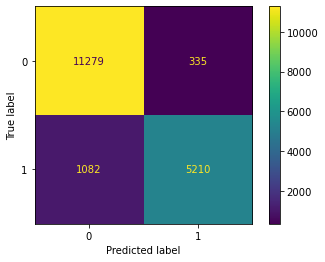

In [79]:
logreg = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42))
])

logreg.fit(x_train[use_cols],y_train)
# logreg.score(x_train[use_cols],y_train)
# x_tr_pr = preprocessor.fit_transform(x_train[use_cols])
# x_te_pr = preprocessor.transform(x_test[use_cols])
displayMetrics(logreg, x_train[use_cols], x_test[use_cols], y_train, y_test)